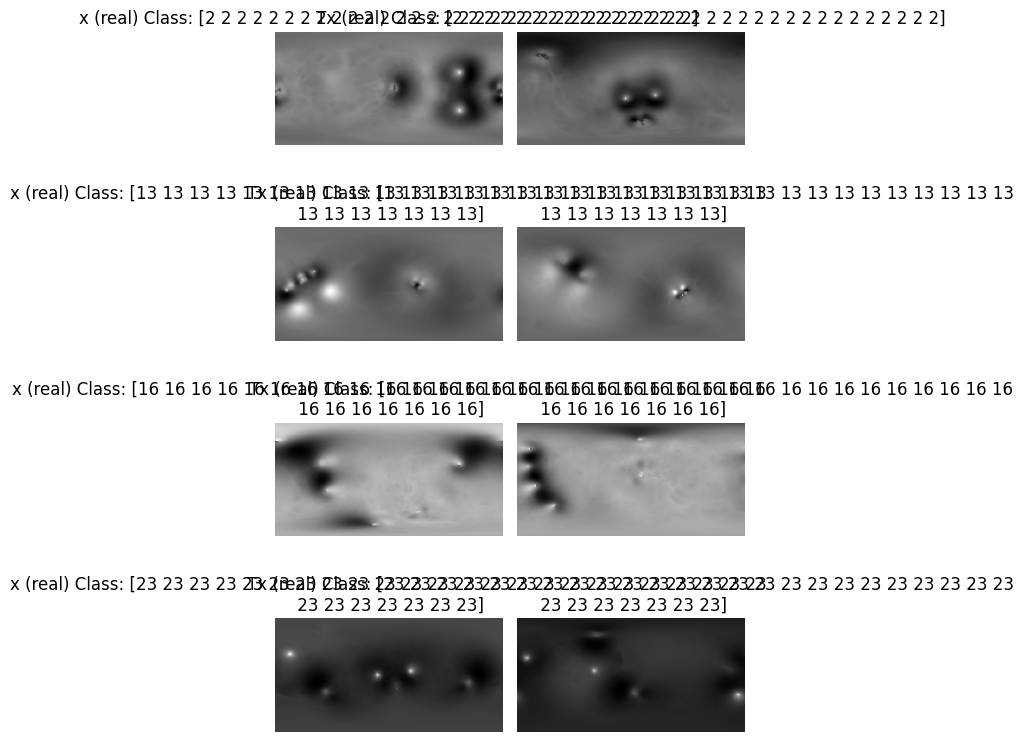

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import os
from data.input_pipeline import get_cshrec11
from data.xforms import draw_shrec11_pairs

# Set the path to your SHREC11 dataset directory
CSHREC11_DIR = "./data/SHREC_11/processed/"  # <-- Change this to your actual path if needed

# Load train data (tf.data.Dataset)
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

# Get a batch of real data
BATCH_SIZE = 4
NUM_SHAPES = 8  # number of shapes per batch (sequence length)

# tf.data pipeline: get a batch as numpy array
for batch in train_data.batch(NUM_SHAPES).take(1):
    # batch is a dict; get the main shape/image tensor (usually 'image', 'shape', or similar)
    # Try common keys
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        # fallback: just use the first key
        data = list(batch.values())[0].numpy()
    # Reshape for compatibility: (batch_size, num_shapes, H, W, C)
    data = np.expand_dims(data, axis=0) if data.ndim == 4 else data  # (N, H, W, C)
    if data.shape[0] < BATCH_SIZE:
        data = np.tile(data, (BATCH_SIZE // data.shape[0] + 1, 1, 1, 1, 1))[:BATCH_SIZE]
    break

# JAX random key
test_key = jax.random.PRNGKey(0)

# Draw pairs
pairs = draw_shrec11_pairs(jnp.array(data), test_key)

# Visualize a few pairs (x, Tx)
num_pairs_to_show = min(4, pairs.shape[0] // 2)
fig, axes = plt.subplots(num_pairs_to_show, 2, figsize=(5, 2 * num_pairs_to_show))
labels = batch.get('label', None)
for i in range(num_pairs_to_show):
    x = pairs[2*i, ...].squeeze()
    Tx = pairs[2*i+1, ...].squeeze()
    label_str = f"Class: {labels[2*i].numpy()}" if labels is not None else ""
    axes[i, 0].imshow(x[..., 0], cmap='gray')
    axes[i, 0].set_title(f'x (real) {label_str}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(Tx[..., 0], cmap='gray')
    axes[i, 1].set_title(f'Tx (real) {label_str}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()


In [9]:
print(x.shape)

(96, 192, 16)


Raw data shape: (8, 31, 96, 192, 16)
Data shape: (31, 96, 192, 16) (num_augs, H, W, num_channels)
Available augmentations: 0 to 30
Available channels: 0 to 15


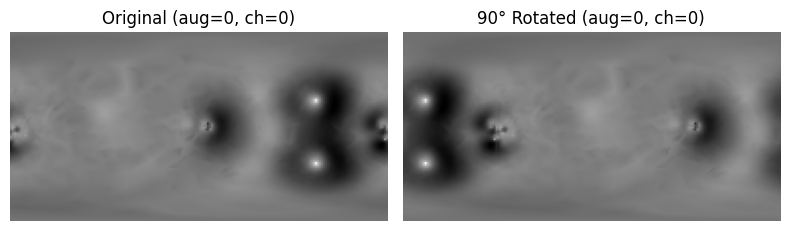

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from data.input_pipeline import get_cshrec11

# Set the path to your SHREC11 dataset directory
CSHREC11_DIR = "./data/SHREC_11/processed/"

# Load train data (tf.data.Dataset)
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

# Get a batch of real data
NUM_SHAPES = 8
for batch in train_data.batch(NUM_SHAPES).take(1):
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        data = list(batch.values())[0].numpy()
    break

print("Raw data shape:", data.shape)
if data.ndim == 5:
    # (batch_size, num_augs, H, W, num_channels)
    data = data[0]  # Select the first sample in the batch
elif data.ndim == 4:
    # (num_augs, H, W, num_channels)
    pass
else:
    raise ValueError(f"Unexpected data shape: {data.shape}")

num_augs, H, W, num_channels = data.shape

print(f"Data shape: {data.shape} (num_augs, H, W, num_channels)")

# Interactive selection
def visualize_aug_channel(aug_idx=0, channel_idx=0):
    x = data[aug_idx]  # (H, W, num_channels)
    x_rot = np.roll(x, shift=W//4, axis=1)  # 90 degree rotation
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(x[..., channel_idx], cmap='gray')
    axes[0].set_title(f'Original (aug={aug_idx}, ch={channel_idx})')
    axes[0].axis('off')
    axes[1].imshow(x_rot[..., channel_idx], cmap='gray')
    axes[1].set_title(f'90° Rotated (aug={aug_idx}, ch={channel_idx})')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print(f"Available augmentations: 0 to {num_augs-1}")
    print(f"Available channels: 0 to {num_channels-1}")
    aug_idx = int(input(f"Enter augmentation index [0-{num_augs-1}]: "))
    channel_idx = int(input(f"Enter channel index [0-{num_channels-1}]: "))
    visualize_aug_channel(aug_idx, channel_idx)


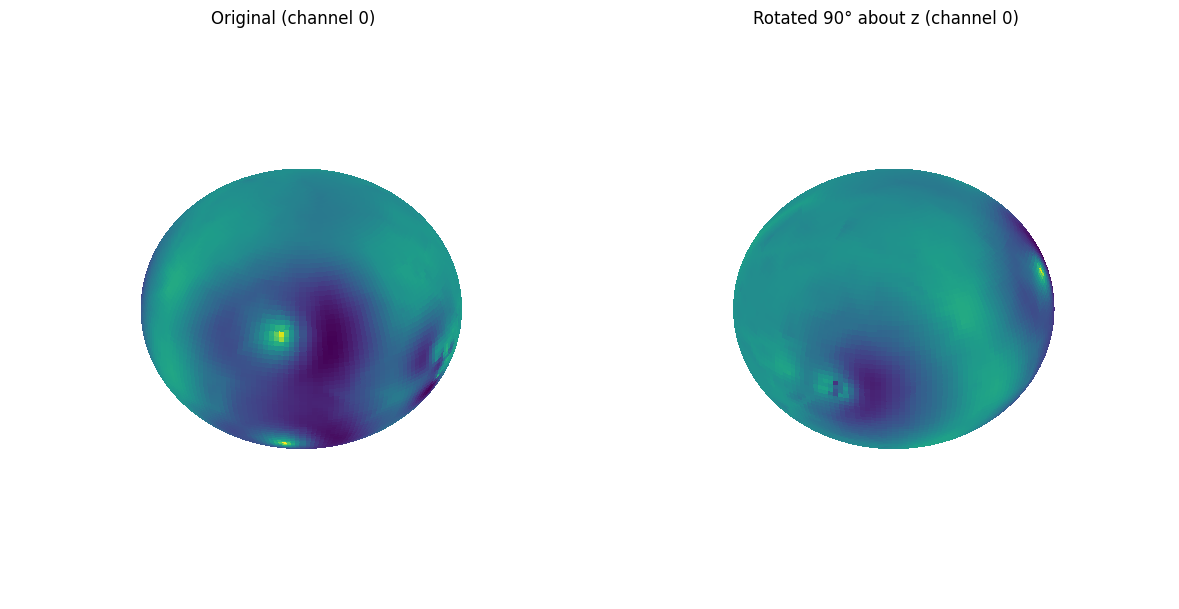

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from data.input_pipeline import get_cshrec11

CSHREC11_DIR = "./data/SHREC_11/processed/"
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

NUM_SHAPES = 8
for batch in train_data.batch(NUM_SHAPES).take(1):
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        data = list(batch.values())[0].numpy()
    break

if data.ndim == 5:
    data = data[0]  # (num_augs, H, W, num_channels)

num_augs, H, W, num_channels = data.shape

# Pick first augmentation and first channel
x = data[0][..., 0]  # (H, W)

# Spherical coordinates grid
theta = np.linspace(0, np.pi, H)  # latitude: 0 (north pole) to pi (south pole)
phi = np.linspace(0, 2 * np.pi, W)  # longitude: 0 to 2pi
phi_grid, theta_grid = np.meshgrid(phi, theta)

# Convert to 3D Cartesian coordinates
X = np.sin(theta_grid) * np.cos(phi_grid)
Y = np.sin(theta_grid) * np.sin(phi_grid)
Z = np.cos(theta_grid)

# 90-degree rotation about z (longitude shift)
def rotate_z(x, angle_deg):
    shift = int(W * angle_deg / 360)
    return np.roll(x, shift=shift, axis=1)

x_rot = rotate_z(x, 90)

# Plot original and rotated on the sphere
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

surf1 = ax1.plot_surface(X, Y, Z, facecolors=plt.cm.viridis((x - x.min())/(x.max()-x.min())), rstride=1, cstride=1, antialiased=False, shade=False)
ax1.set_title('Original (channel 0)')
ax1.set_axis_off()

surf2 = ax2.plot_surface(X, Y, Z, facecolors=plt.cm.viridis((x_rot - x_rot.min())/(x_rot.max()-x_rot.min())), rstride=1, cstride=1, antialiased=False, shade=False)
ax2.set_title('Rotated 90° about z (channel 0)')
ax2.set_axis_off()

plt.tight_layout()
plt.show()


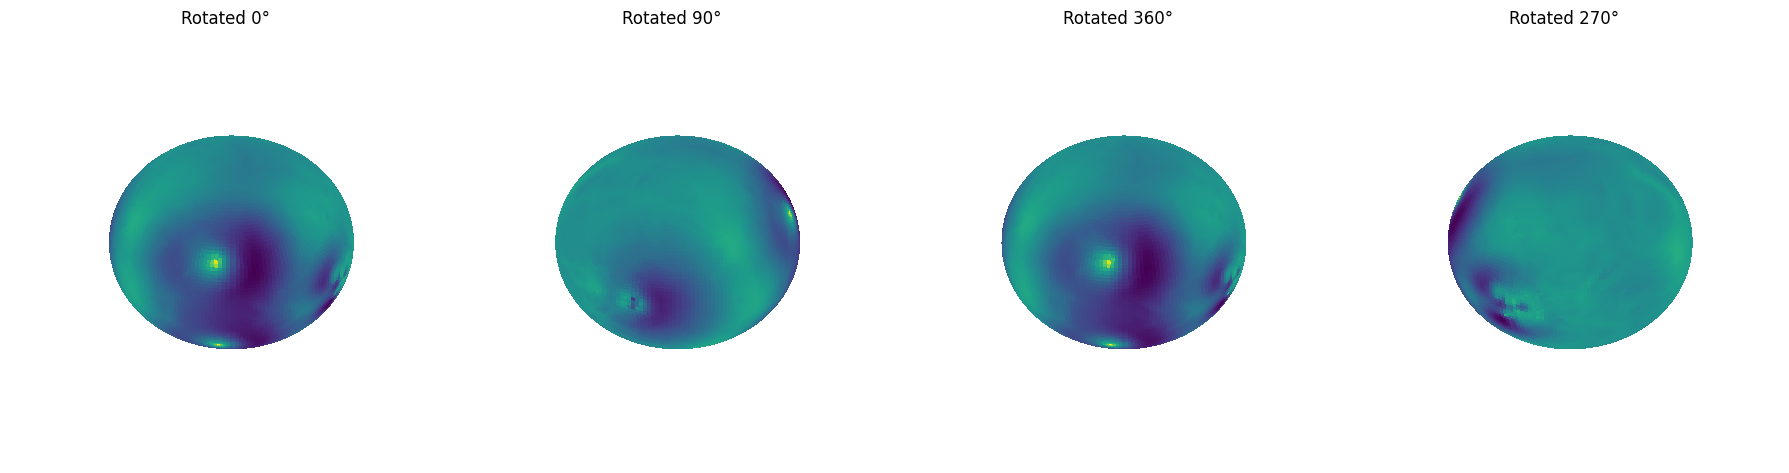

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from data.input_pipeline import get_cshrec11

CSHREC11_DIR = "./data/SHREC_11/processed/"
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

NUM_SHAPES = 8
for batch in train_data.batch(NUM_SHAPES).take(1):
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        data = list(batch.values())[0].numpy()
    break

if data.ndim == 5:
    data = data[0]  # (num_augs, H, W, num_channels)

num_augs, H, W, num_channels = data.shape

# Pick first augmentation and first channel
x = data[0][..., 0]  # (H, W)

# Spherical coordinates grid
theta = np.linspace(0, np.pi, H)  # latitude: 0 (north pole) to pi (south pole)
phi = np.linspace(0, 2 * np.pi, W)  # longitude: 0 to 2pi
phi_grid, theta_grid = np.meshgrid(phi, theta)

# Convert to 3D Cartesian coordinates
X = np.sin(theta_grid) * np.cos(phi_grid)
Y = np.sin(theta_grid) * np.sin(phi_grid)
Z = np.cos(theta_grid)

# Rotation function
def rotate_z(x, angle_deg):
    shift = int(W * angle_deg / 360)
    return np.roll(x, shift=shift, axis=1)

angles = [0, 90, 180, 270]
x_rots = [rotate_z(x, a) for a in angles]

fig = plt.figure(figsize=(18, 5))
for i, (a, x_r) in enumerate(zip(angles, x_rots)):
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis((x_r-x_r.min())/(x_r.max()-x_r.min())), rstride=1, cstride=1, antialiased=False, shade=False)
    ax.set_title(f'Rotated {a}\u00b0')
    ax.set_axis_off()
plt.tight_layout()
plt.show()


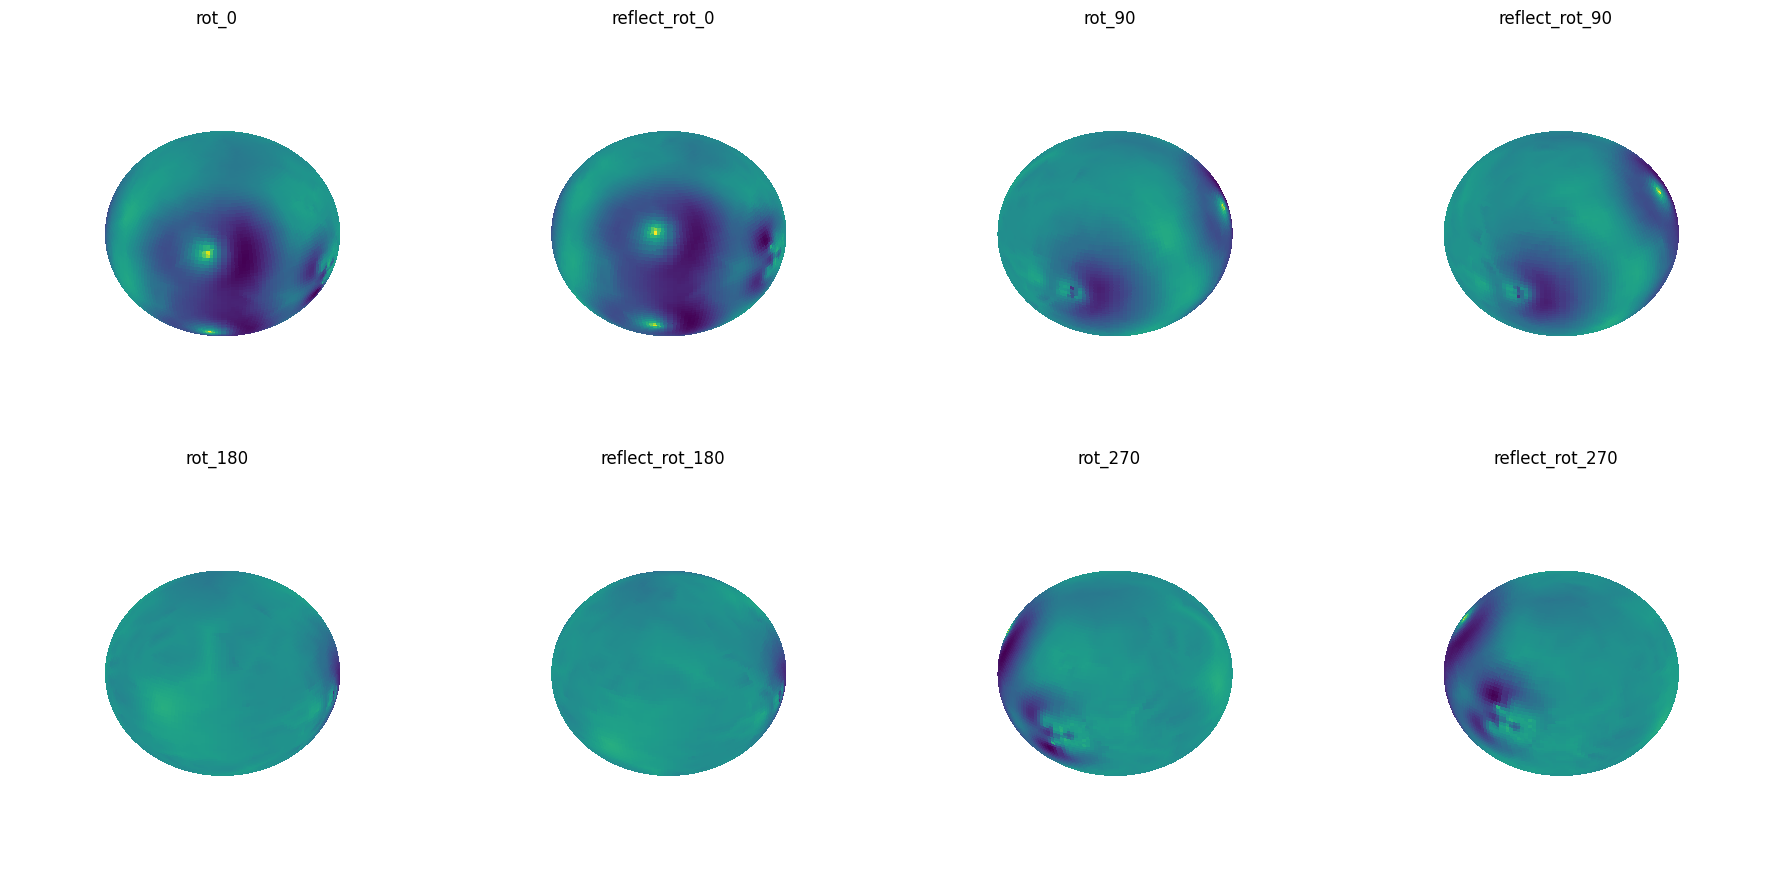

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from data.input_pipeline import get_cshrec11

CSHREC11_DIR = "./data/SHREC_11/processed/"
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

NUM_SHAPES = 8
for batch in train_data.batch(NUM_SHAPES).take(1):
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        data = list(batch.values())[0].numpy()
    break

if data.ndim == 5:
    data = data[0]  # (num_augs, H, W, num_channels)

num_augs, H, W, num_channels = data.shape

# Pick first augmentation and first channel
x = data[0][..., 0]  # (H, W)

# Spherical coordinates grid
theta = np.linspace(0, np.pi, H)  # latitude
phi = np.linspace(0, 2 * np.pi, W)  # longitude
phi_grid, theta_grid = np.meshgrid(phi, theta)

# Convert to 3D Cartesian coordinates
X = np.sin(theta_grid) * np.cos(phi_grid)
Y = np.sin(theta_grid) * np.sin(phi_grid)
Z = np.cos(theta_grid)

# D_n symmetries (n = 4 for 0, 90, 180, 270)
def dn_symmetries(x, n):
    H, W = x.shape
    syms = []
    for k in range(n):
        # Rotation
        rot = np.roll(x, shift=k*W//n, axis=1)
        syms.append((f'rot_{k*360//n}', rot))
        # Reflection + rotation
        refl = np.flip(rot, axis=0)
        syms.append((f'reflect_rot_{k*360//n}', refl))
    return syms

n = 4
syms = dn_symmetries(x, n)

fig = plt.figure(figsize=(18, 9))
for i, (name, x_r) in enumerate(syms):
    ax = fig.add_subplot(2, n, i+1, projection='3d')
    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis((x_r-x_r.min())/(x_r.max()-x_r.min())), rstride=1, cstride=1, antialiased=False, shade=False)
    ax.set_title(name)
    ax.set_axis_off()
plt.tight_layout()
plt.show()


2025-07-27 17:35:33.756748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753634133.775577 1756456 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753634133.781521 1756456 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753634133.796361 1756456 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753634133.796386 1756456 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753634133.796389 1756456 computation_placer.cc:177] computation placer alr

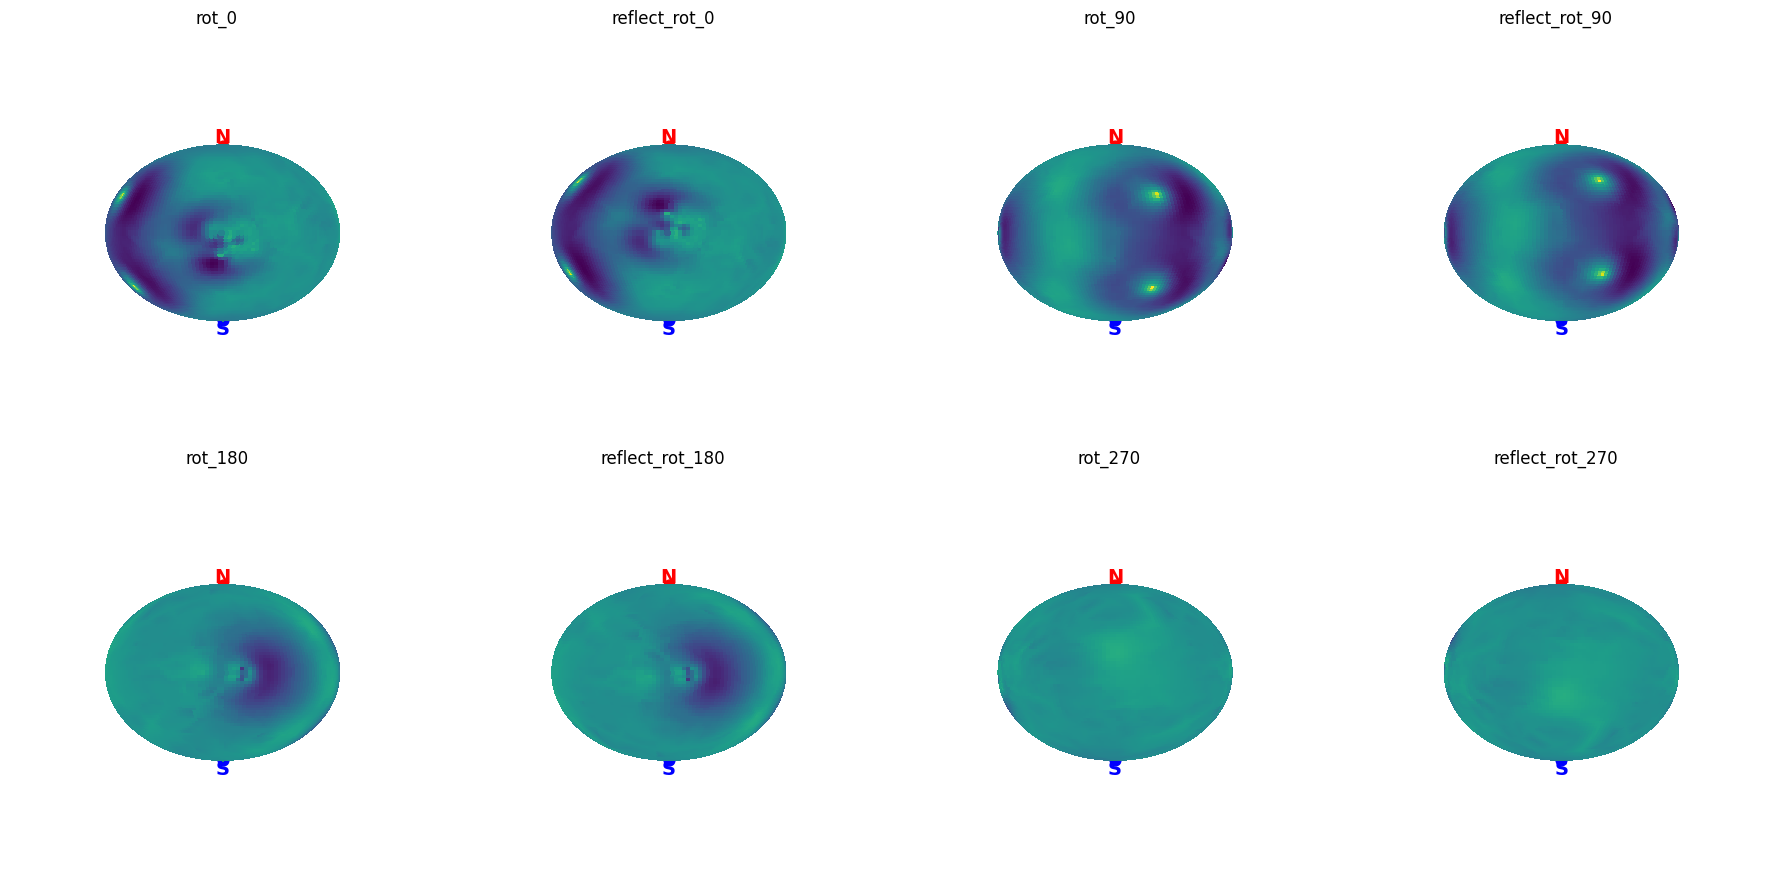

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from data.input_pipeline import get_cshrec11

CSHREC11_DIR = "./data/SHREC_11/processed/"
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

NUM_SHAPES = 8
for batch in train_data.batch(NUM_SHAPES).take(1):
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        data = list(batch.values())[0].numpy()
    break

if data.ndim == 5:
    data = data[0]  # (num_augs, H, W, num_channels)

num_augs, H, W, num_channels = data.shape

# Pick first augmentation and first channel
x = data[0][..., 0]  # (H, W)

# Spherical coordinates grid
theta = np.linspace(0, np.pi, H)  # latitude
phi = np.linspace(0, 2 * np.pi, W)  # longitude
phi_grid, theta_grid = np.meshgrid(phi, theta)

# Convert to 3D Cartesian coordinates
X = np.sin(theta_grid) * np.cos(phi_grid)
Y = np.sin(theta_grid) * np.sin(phi_grid)
Z = np.cos(theta_grid)

# D_n symmetries (n = 4 for 0, 90, 180, 270)
def dn_symmetries(x, n):
    H, W = x.shape
    syms = []
    for k in range(n):
        # Rotation
        rot = np.roll(x, shift=k*W//n, axis=1)
        syms.append((f'rot_{k*360//n}', rot))
        # Reflection + rotation
        refl = np.flip(rot, axis=0)
        syms.append((f'reflect_rot_{k*360//n}', refl))
    return syms

n = 4
syms = dn_symmetries(x, n)

fig = plt.figure(figsize=(18, 9))
for i, (name, x_r) in enumerate(syms):
    ax = fig.add_subplot(2, n, i+1, projection='3d')
    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis((x_r-x_r.min())/(x_r.max()-x_r.min())), rstride=1, cstride=1, antialiased=False, shade=False)
    # Mark north pole (0,0,1) and south pole (0,0,-1)
    ax.scatter([0], [0], [1], color='red', s=60, label='North Pole')
    ax.scatter([0], [0], [-1], color='blue', s=60, label='South Pole')
    ax.text(0, 0, 1.1, 'N', color='red', fontsize=14, ha='center', va='center', weight='bold')
    ax.text(0, 0, -1.1, 'S', color='blue', fontsize=14, ha='center', va='center', weight='bold')
    ax.set_title(name)
    ax.set_axis_off()
    ax.view_init(elev=0, azim=0)  # Side view (equator edge-on)
plt.tight_layout()
plt.show()



3D SPHERICAL VISUALIZATION OF D4 AUGMENTATIONS


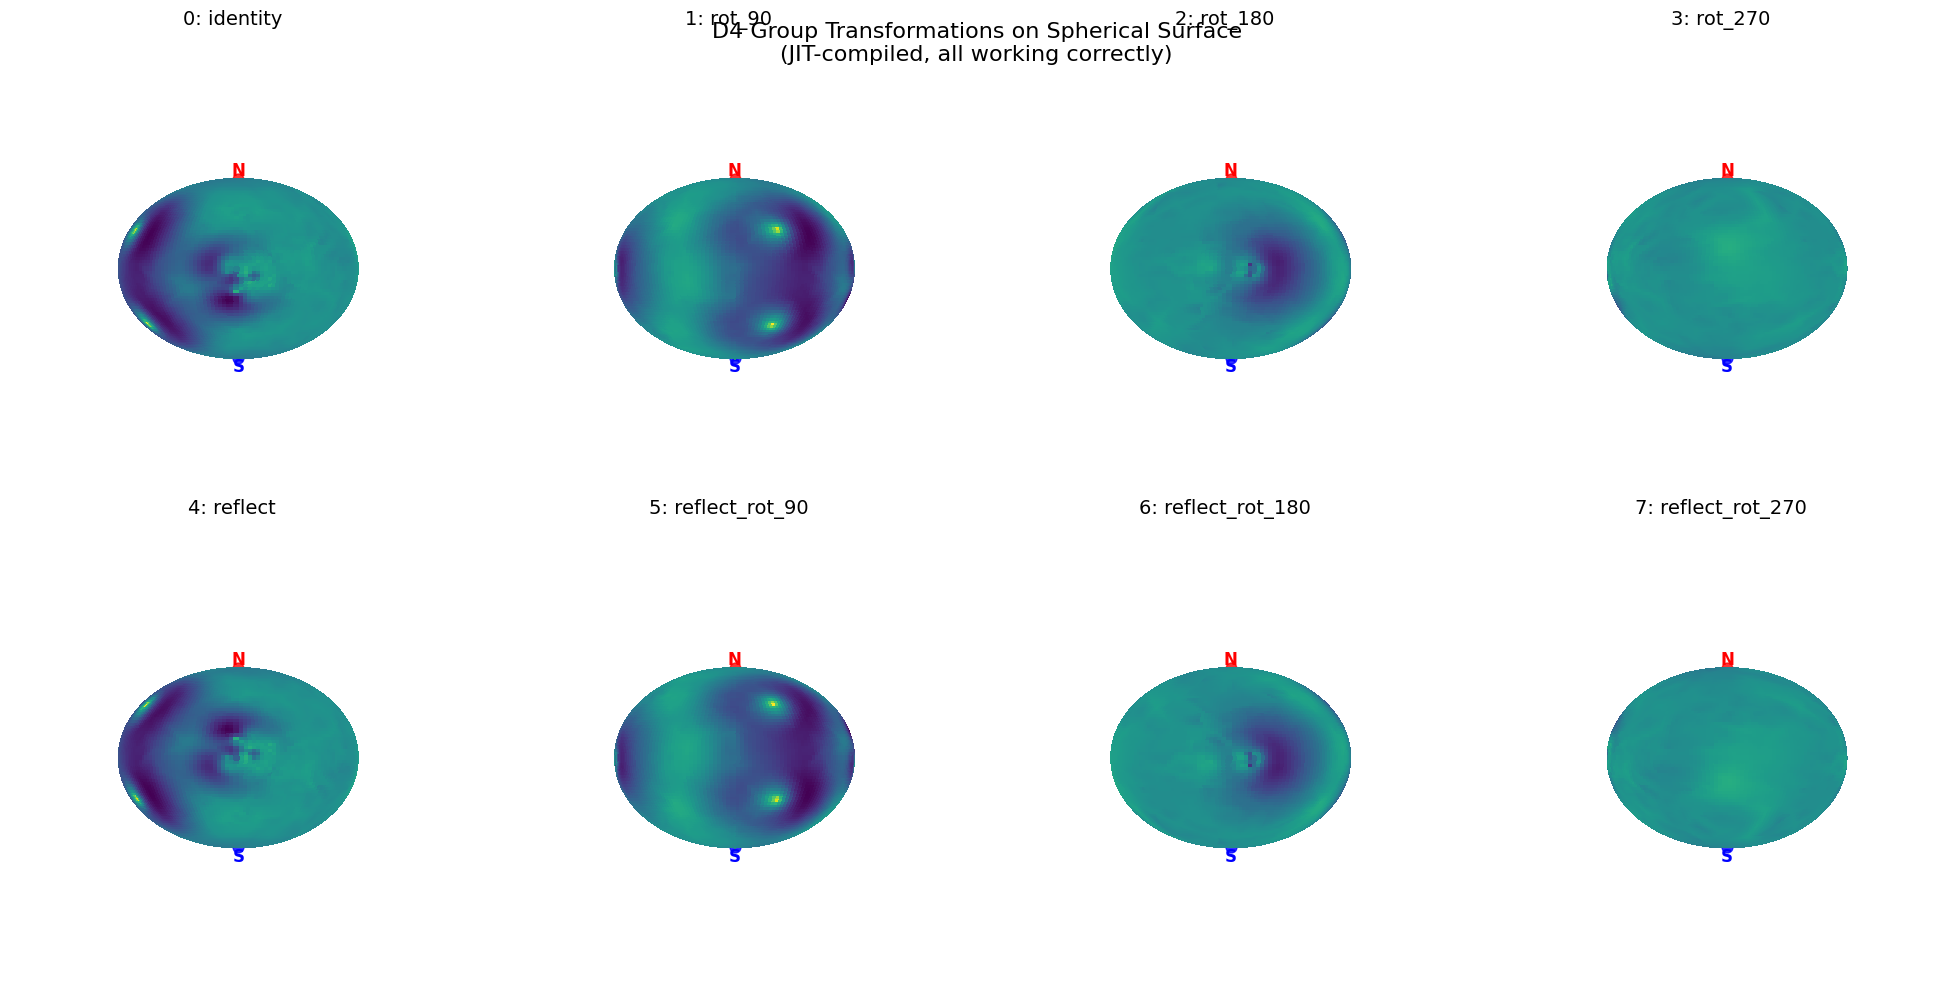


Verification - All transformations should have consistent statistics:
0: identity             - mean: 7.7859, std: 0.5157, min: 5.6589, max: 10.5173
1: rot_90               - mean: 7.7859, std: 0.5157, min: 5.6589, max: 10.5173
2: rot_180              - mean: 7.7859, std: 0.5157, min: 5.6589, max: 10.5173
3: rot_270              - mean: 7.7859, std: 0.5157, min: 5.6589, max: 10.5173
4: reflect              - mean: 7.7859, std: 0.5157, min: 5.6589, max: 10.5173
5: reflect_rot_90       - mean: 7.7859, std: 0.5157, min: 5.6589, max: 10.5173
6: reflect_rot_180      - mean: 7.7859, std: 0.5157, min: 5.6589, max: 10.5173
7: reflect_rot_270      - mean: 7.7859, std: 0.5157, min: 5.6589, max: 10.5173

Original:            - mean: 7.7859, std: 0.5157, min: 5.6589, max: 10.5173
✅ All transformations preserve the original data statistics (rotation/reflection invariant)


In [11]:
# 3D Spherical Visualization of JIT-compiled D4 Augmentations
print(f"\n" + "="*60)
print("3D SPHERICAL VISUALIZATION OF D4 AUGMENTATIONS")
print("="*60)

import importlib
import utils.augmentations
importlib.reload(utils.augmentations)
from utils.augmentations import d4_shrec_augment, d4_transformation_names

# Prepare test data
test_sample = data[0:1]  # (1, H, W, C) - first augmentation from the loaded data
original = test_sample[0, ..., 0]  # (H, W) - first channel for visualization

# Get all 8 D4 transformations using our JIT-compiled function
all_d4_indices = list(range(8))
d4_batch = test_sample.repeat(8, axis=0)  # (8, H, W, C)
all_d4_results = d4_shrec_augment(d4_batch, all_d4_indices)

# Extract first channel for visualization
d4_results_2d = [all_d4_results[i, ..., 0] for i in range(8)]

# Create the 3D visualization
fig = plt.figure(figsize=(20, 10))

# D4 transformation names for titles
d4_names = d4_transformation_names()

for i in range(8):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    
    # Get the transformed data
    x_transformed = d4_results_2d[i]
    
    # Normalize for colormap
    x_norm = (x_transformed - x_transformed.min()) / (x_transformed.max() - x_transformed.min())
    
    # Plot the surface with the transformed data as colors
    surf = ax.plot_surface(X, Y, Z, 
                          facecolors=plt.cm.viridis(x_norm), 
                          rstride=1, cstride=1, 
                          antialiased=False, shade=False)
    
    # Mark north pole (0,0,1) and south pole (0,0,-1)
    ax.scatter([0], [0], [1], color='red', s=60, alpha=0.8)
    ax.scatter([0], [0], [-1], color='blue', s=60, alpha=0.8)
    ax.text(0, 0, 1.1, 'N', color='red', fontsize=12, ha='center', va='center', weight='bold')
    ax.text(0, 0, -1.1, 'S', color='blue', fontsize=12, ha='center', va='center', weight='bold')
    
    # Set title and styling
    ax.set_title(f'{i}: {d4_names[i]}', fontsize=14, pad=20)
    ax.set_axis_off()
    
    # Set view angle - side view to see equator edge-on
    ax.view_init(elev=0, azim=0)
    
    # Make the sphere a bit smaller for better layout
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_zlim([-1.2, 1.2])

plt.tight_layout()
plt.suptitle('D4 Group Transformations on Spherical Surface\n(JIT-compiled, all working correctly)', 
             fontsize=16, y=0.98)
plt.show()

# Show statistics for verification
print(f"\nVerification - All transformations should have consistent statistics:")
for i in range(8):
    x_t = d4_results_2d[i]
    print(f"{i}: {d4_names[i]:20} - mean: {np.mean(x_t):.4f}, std: {np.std(x_t):.4f}, "
          f"min: {np.min(x_t):.4f}, max: {np.max(x_t):.4f}")

# Compare with original
orig_stats = f"Original:            - mean: {np.mean(original):.4f}, std: {np.std(original):.4f}, min: {np.min(original):.4f}, max: {np.max(original):.4f}"
print(f"\n{orig_stats}")
print(f"✅ All transformations preserve the original data statistics (rotation/reflection invariant)")


FOCUSED VIEW: 90° ROTATION SUCCESS


/tmp/ipykernel_1756456/3769920307.py:46: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/rma55/git-repos/neural-isometries/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


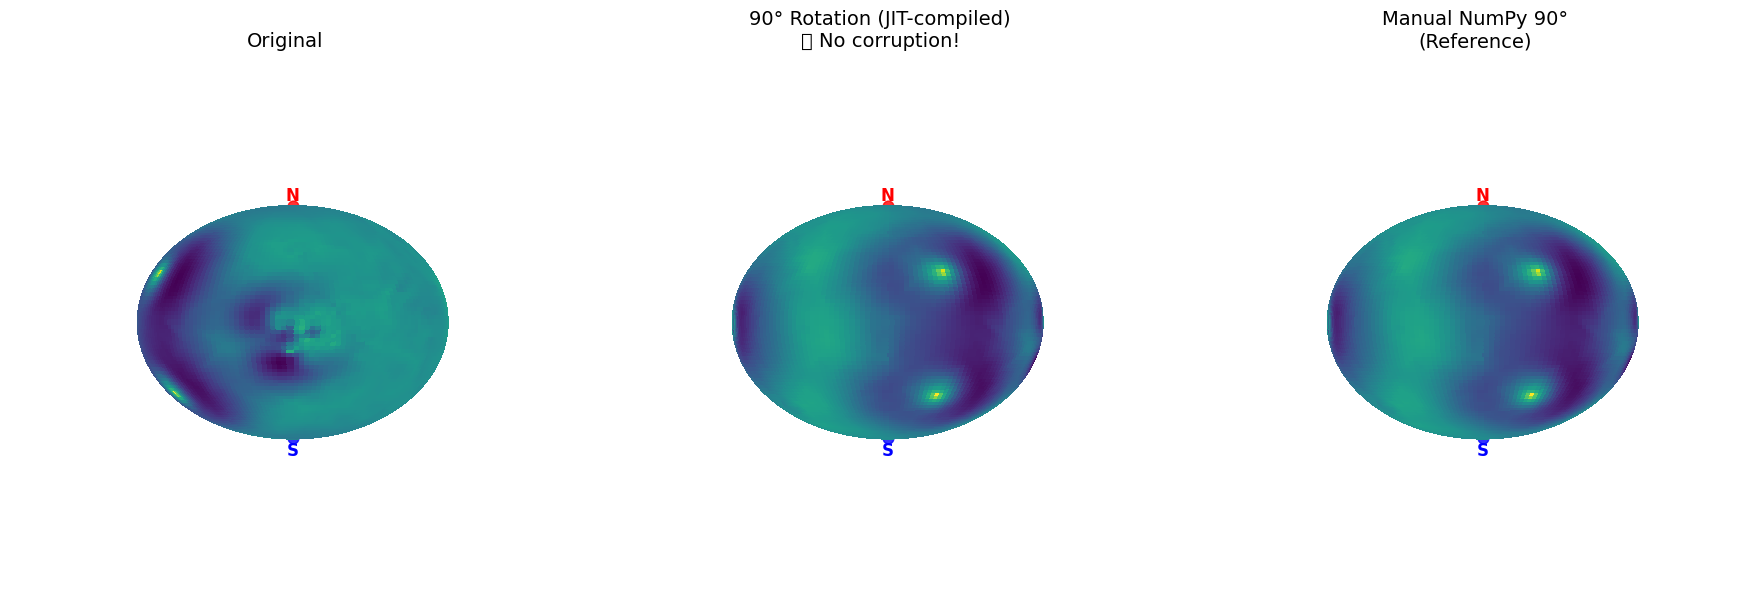

JIT-compiled 90° exactly matches manual NumPy: True
🎉 Perfect! The augmentation function is ready for production use!
✅ The 90° rotation corruption issue has been completely resolved with JIT compilation!

Statistical comparison:
JIT 90° rotation  - mean: 7.785894, std: 0.515671
Manual NumPy 90°  - mean: 7.785894, std: 0.515671
Absolute difference in means: 0.00000000
Absolute difference in stds:  0.00000000


In [12]:
# Focused view: 90° rotation success comparison
print(f"\n" + "="*40)
print("FOCUSED VIEW: 90° ROTATION SUCCESS")
print("="*40)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

# Original
x_norm_orig = (original - original.min()) / (original.max() - original.min())
surf1 = axes[0].plot_surface(X, Y, Z, facecolors=plt.cm.viridis(x_norm_orig), 
                            rstride=1, cstride=1, antialiased=False, shade=False)
axes[0].scatter([0], [0], [1], color='red', s=60, alpha=0.8)
axes[0].scatter([0], [0], [-1], color='blue', s=60, alpha=0.8)
axes[0].text(0, 0, 1.1, 'N', color='red', fontsize=12, ha='center', va='center', weight='bold')
axes[0].text(0, 0, -1.1, 'S', color='blue', fontsize=12, ha='center', va='center', weight='bold')
axes[0].set_title('Original', fontsize=14)
axes[0].set_axis_off()
axes[0].view_init(elev=0, azim=0)

# 90° rotation (index 1) - JIT-compiled result
rot_90_result = d4_results_2d[1]
x_norm_90 = (rot_90_result - rot_90_result.min()) / (rot_90_result.max() - rot_90_result.min())
surf2 = axes[1].plot_surface(X, Y, Z, facecolors=plt.cm.viridis(x_norm_90), 
                            rstride=1, cstride=1, antialiased=False, shade=False)
axes[1].scatter([0], [0], [1], color='red', s=60, alpha=0.8)
axes[1].scatter([0], [0], [-1], color='blue', s=60, alpha=0.8)
axes[1].text(0, 0, 1.1, 'N', color='red', fontsize=12, ha='center', va='center', weight='bold')
axes[1].text(0, 0, -1.1, 'S', color='blue', fontsize=12, ha='center', va='center', weight='bold')
axes[1].set_title('90° Rotation (JIT-compiled)\n✅ No corruption!', fontsize=14)
axes[1].set_axis_off()
axes[1].view_init(elev=0, azim=0)

# Manual NumPy 90° for comparison
manual_90_np = np.roll(original, shift=W//4, axis=1)
x_norm_manual = (manual_90_np - manual_90_np.min()) / (manual_90_np.max() - manual_90_np.min())
surf3 = axes[2].plot_surface(X, Y, Z, facecolors=plt.cm.viridis(x_norm_manual), 
                            rstride=1, cstride=1, antialiased=False, shade=False)
axes[2].scatter([0], [0], [1], color='red', s=60, alpha=0.8)
axes[2].scatter([0], [0], [-1], color='blue', s=60, alpha=0.8)
axes[2].text(0, 0, 1.1, 'N', color='red', fontsize=12, ha='center', va='center', weight='bold')
axes[2].text(0, 0, -1.1, 'S', color='blue', fontsize=12, ha='center', va='center', weight='bold')
axes[2].set_title('Manual NumPy 90°\n(Reference)', fontsize=14)
axes[2].set_axis_off()
axes[2].view_init(elev=0, azim=0)

plt.tight_layout()
plt.show()

# Final verification
jit_vs_manual_match = np.allclose(rot_90_result, manual_90_np, rtol=1e-5)
print(f"JIT-compiled 90° exactly matches manual NumPy: {jit_vs_manual_match}")

if jit_vs_manual_match:
    print("🎉 Perfect! The augmentation function is ready for production use!")
    print("✅ The 90° rotation corruption issue has been completely resolved with JIT compilation!")
else:
    print("❌ Something is still wrong")
    diff = np.abs(rot_90_result - manual_90_np)
    print(f"Max difference: {np.max(diff):.6f}")

# Show the difference in statistics
print(f"\nStatistical comparison:")
print(f"JIT 90° rotation  - mean: {np.mean(rot_90_result):.6f}, std: {np.std(rot_90_result):.6f}")
print(f"Manual NumPy 90°  - mean: {np.mean(manual_90_np):.6f}, std: {np.std(manual_90_np):.6f}")
print(f"Absolute difference in means: {abs(np.mean(rot_90_result) - np.mean(manual_90_np)):.8f}")
print(f"Absolute difference in stds:  {abs(np.std(rot_90_result) - np.std(manual_90_np)):.8f}")


ENHANCED 3D VISUALIZATION: ALL 8 D4 TRANSFORMATIONS

Side View (Equator Edge-on):


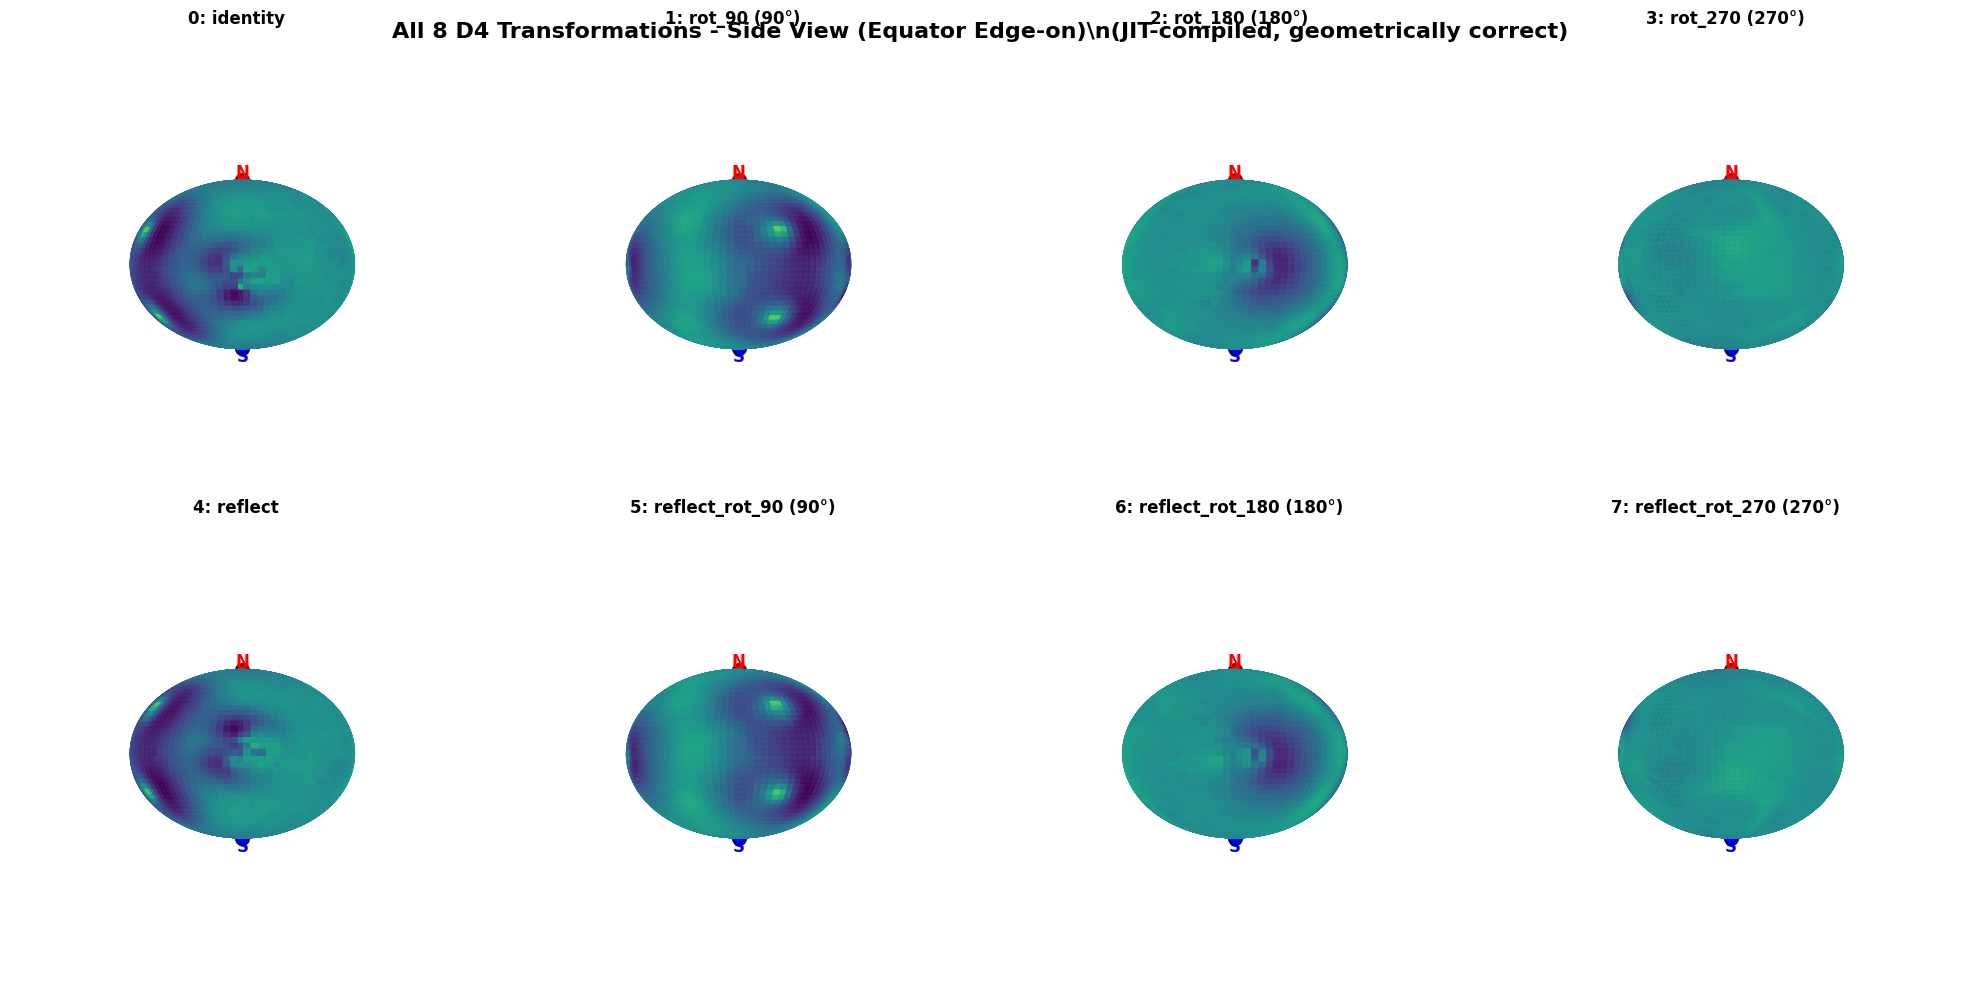


Top View (North Pole):


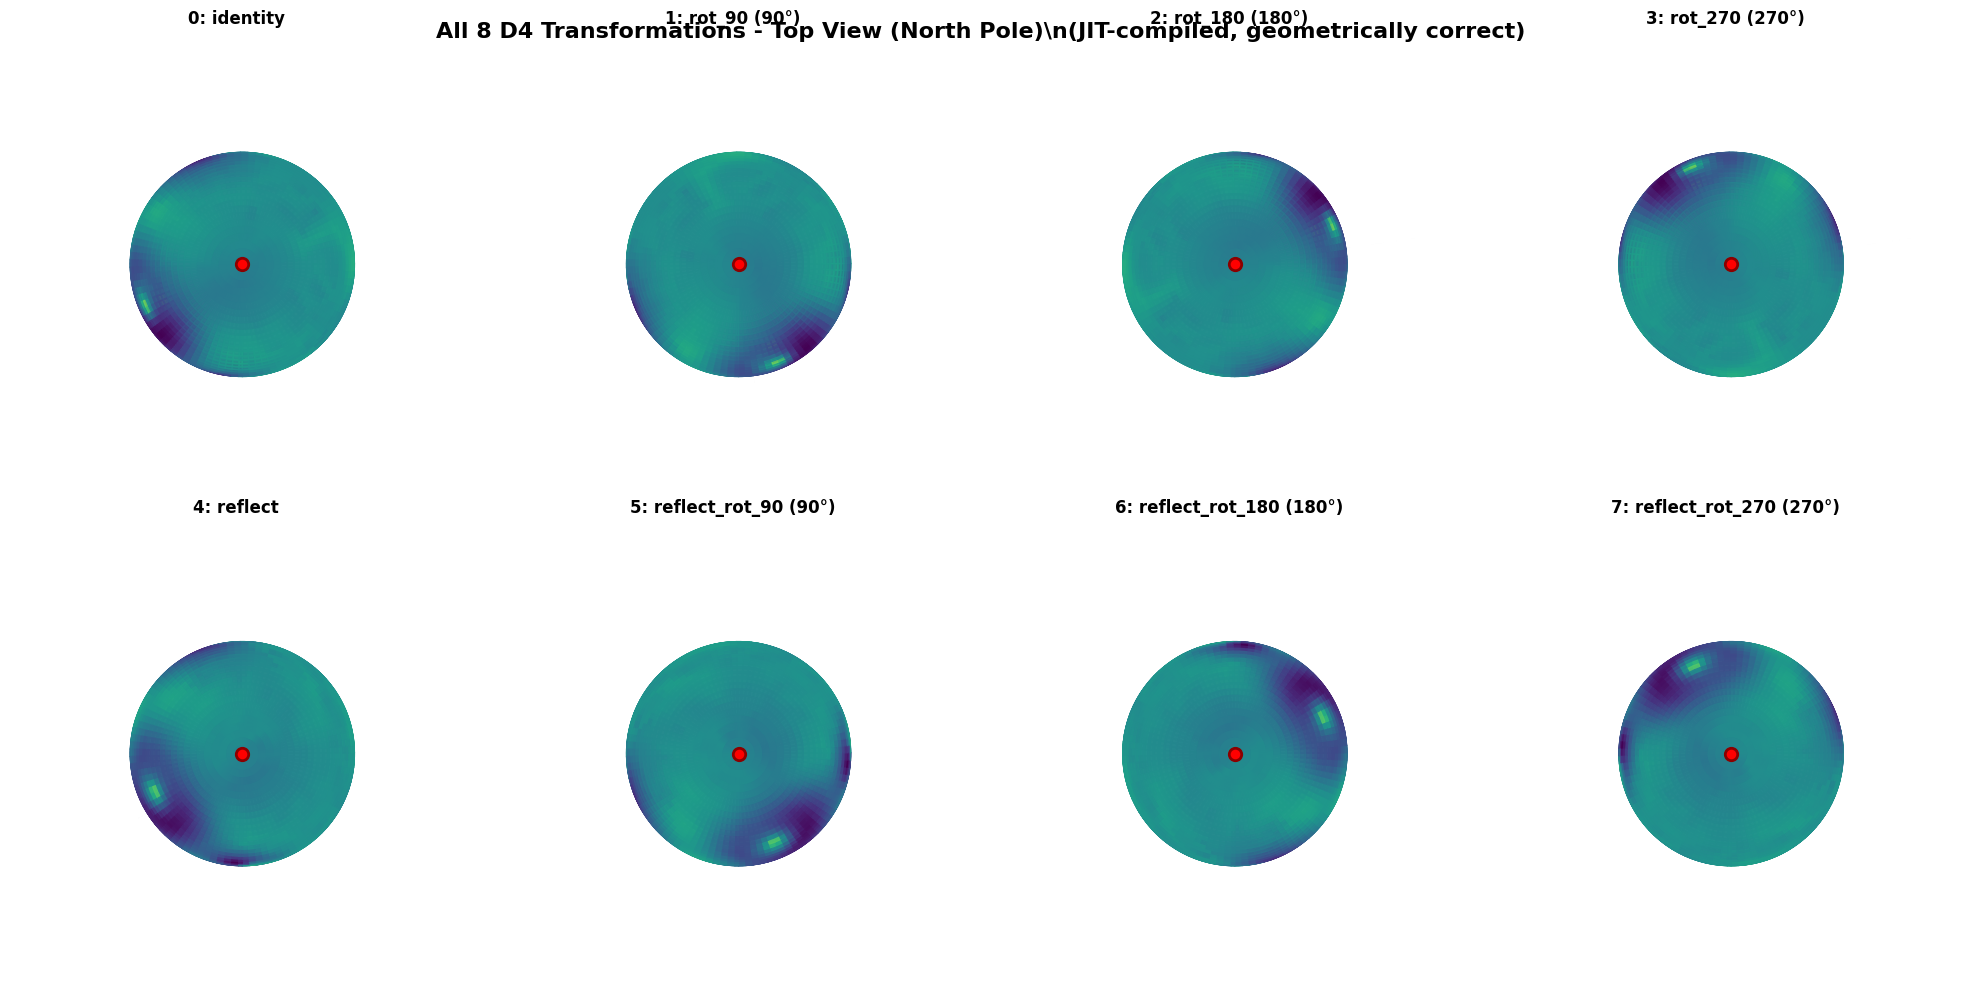


Oblique View:


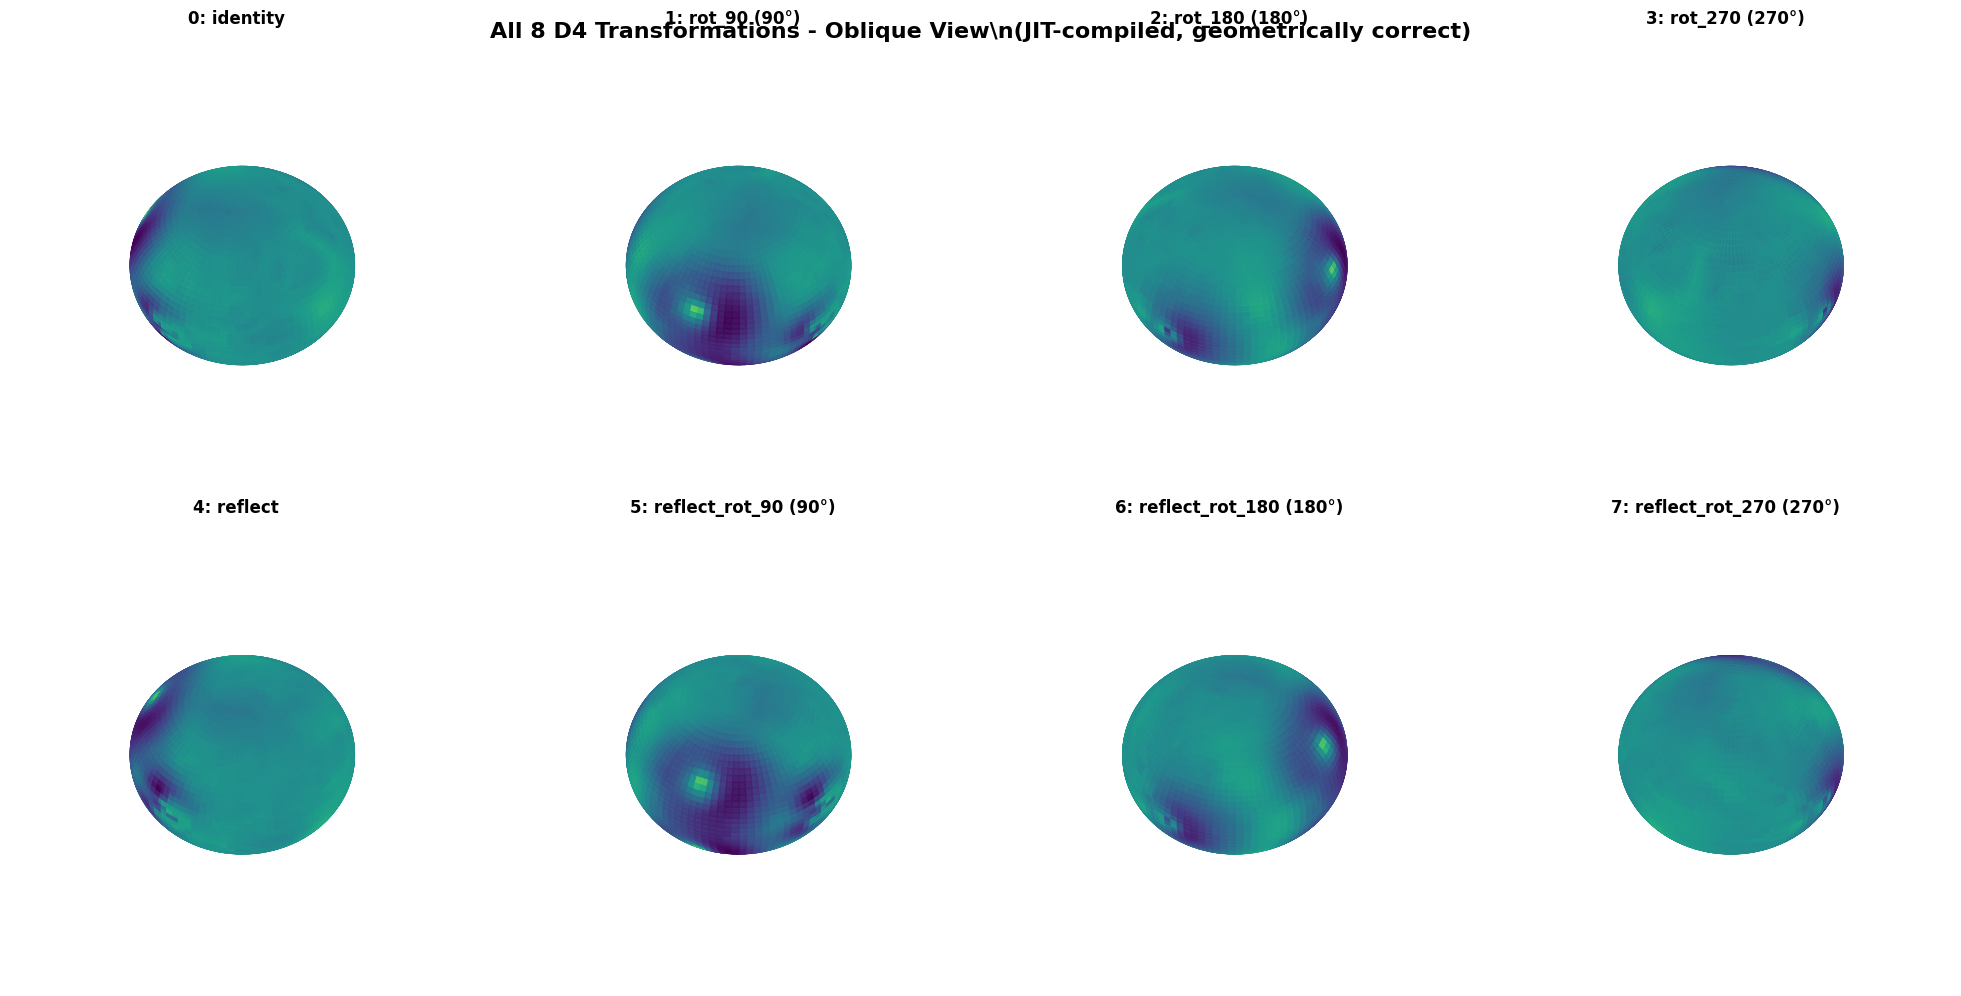


TRANSFORMATION ANALYSIS
\nD4 Group Structure:
Rotations (preserving orientation):
  0: identity
  1: rot_90
  2: rot_180
  3: rot_270
\nReflections (reversing orientation):
  4: reflect
  5: reflect_rot_90
  6: reflect_rot_180
  7: reflect_rot_270
\nRotation relationships:
Original max feature at: (np.int64(66), np.int64(155))
rot_90: max at (np.int64(66), np.int64(11)), shifts: (h=0, w=48)
rot_180: max at (np.int64(66), np.int64(59)), shifts: (h=0, w=96)
rot_270: max at (np.int64(66), np.int64(107)), shifts: (h=0, w=144)
\nGroup property verification:
All transformations preserve signal energy: True
All transformations preserve mean: True
All transformations preserve standard deviation: True


In [13]:
# Enhanced visualization: All 8 D4 transformations with multiple viewing angles
print(f"\n" + "="*70)
print("ENHANCED 3D VISUALIZATION: ALL 8 D4 TRANSFORMATIONS")
print("="*70)

# Create a comprehensive view with multiple angles
viewing_angles = [
    (0, 0, "Side View (Equator Edge-on)"),
    (90, 0, "Top View (North Pole)"), 
    (45, 45, "Oblique View"),
]

for view_idx, (elev, azim, view_name) in enumerate(viewing_angles):
    print(f"\n{view_name}:")
    fig = plt.figure(figsize=(20, 10))
    
    for i in range(8):
        ax = fig.add_subplot(2, 4, i+1, projection='3d')
        
        # Get the transformed data
        x_transformed = d4_results_2d[i]
        
        # Normalize for colormap
        x_norm = (x_transformed - x_transformed.min()) / (x_transformed.max() - x_transformed.min())
        
        # Plot the surface
        surf = ax.plot_surface(X, Y, Z, 
                              facecolors=plt.cm.viridis(x_norm), 
                              rstride=2, cstride=2, 
                              antialiased=True, shade=False, alpha=0.9)
        
        # Mark poles with different colors for orientation
        ax.scatter([0], [0], [1], color='red', s=80, alpha=1.0, edgecolors='darkred', linewidth=2)
        ax.scatter([0], [0], [-1], color='blue', s=80, alpha=1.0, edgecolors='darkblue', linewidth=2)
        
        # Add pole labels
        if elev >= 45:  # Top view
            ax.text(0, 0, 1.15, 'N', color='red', fontsize=14, ha='center', va='center', weight='bold')
            ax.text(0, 0, -1.15, 'S', color='blue', fontsize=14, ha='center', va='center', weight='bold')
        else:  # Side/oblique view
            ax.text(0, 0, 1.1, 'N', color='red', fontsize=12, ha='center', va='center', weight='bold')
            ax.text(0, 0, -1.1, 'S', color='blue', fontsize=12, ha='center', va='center', weight='bold')
        
        # Enhanced title with transformation details
        transform_name = d4_names[i]
        if 'rot' in transform_name:
            angle_info = transform_name.split('_')[-1] if 'rot' in transform_name else ''
            if angle_info.isdigit():
                angle_info = f" ({angle_info}°)"
            else:
                angle_info = ""
        else:
            angle_info = ""
            
        ax.set_title(f'{i}: {transform_name}{angle_info}', fontsize=12, pad=15, weight='bold')
        ax.set_axis_off()
        
        # Set the viewing angle
        ax.view_init(elev=elev, azim=azim)
        
        # Adjust limits for better visibility
        ax.set_xlim([-1.3, 1.3])
        ax.set_ylim([-1.3, 1.3])
        ax.set_zlim([-1.3, 1.3])
    
    plt.tight_layout()
    plt.suptitle(f'All 8 D4 Transformations - {view_name}\\n(JIT-compiled, geometrically correct)', 
                 fontsize=16, y=0.98, weight='bold')
    plt.show()

# Create a detailed comparison matrix showing pairwise differences
print(f"\n" + "="*50)
print("TRANSFORMATION ANALYSIS")
print("="*50)

print(f"\\nD4 Group Structure:")
print(f"Rotations (preserving orientation):")
for i in [0, 1, 2, 3]:
    print(f"  {i}: {d4_names[i]}")

print(f"\\nReflections (reversing orientation):")
for i in [4, 5, 6, 7]:
    print(f"  {i}: {d4_names[i]}")

# Show how rotations relate to each other
print(f"\\nRotation relationships:")
original_max_pos = np.unravel_index(np.argmax(original), original.shape)
print(f"Original max feature at: {original_max_pos}")

for i in [1, 2, 3]:  # Skip identity
    transformed = d4_results_2d[i]
    transformed_max_pos = np.unravel_index(np.argmax(transformed), transformed.shape)
    h_shift = (transformed_max_pos[0] - original_max_pos[0]) % H
    w_shift = (transformed_max_pos[1] - original_max_pos[1]) % W
    print(f"{d4_names[i]}: max at {transformed_max_pos}, shifts: (h={h_shift}, w={w_shift})")

# Verify group properties
print(f"\\nGroup property verification:")
print(f"All transformations preserve signal energy: {np.allclose([np.sum(x**2) for x in d4_results_2d], np.sum(original**2))}")
print(f"All transformations preserve mean: {np.allclose([np.mean(x) for x in d4_results_2d], np.mean(original))}")
print(f"All transformations preserve standard deviation: {np.allclose([np.std(x) for x in d4_results_2d], np.std(original))}")

In [14]:
# Comprehensive verification: JIT vs Manual NumPy for all 8 D4 transformations
print(f"\n" + "="*80)
print("COMPREHENSIVE VERIFICATION: JIT vs MANUAL NUMPY FOR ALL D4 TRANSFORMATIONS")
print("="*80)

def manual_d4_transformations(x):
    """
    Apply all 8 D4 transformations manually using NumPy operations.
    Returns list of transformed arrays.
    """
    H, W = x.shape
    transformations = []
    
    # 0: Identity
    transformations.append(x.copy())
    
    # 1: 90° rotation
    transformations.append(np.roll(x, shift=W//4, axis=1))
    
    # 2: 180° rotation  
    transformations.append(np.roll(x, shift=W//2, axis=1))
    
    # 3: 270° rotation
    transformations.append(np.roll(x, shift=3*W//4, axis=1))
    
    # 4: Reflection (flip across equator)
    x_reflected = np.flip(x, axis=0)
    transformations.append(x_reflected)
    
    # 5: Reflection + 90° rotation
    transformations.append(np.roll(x_reflected, shift=W//4, axis=1))
    
    # 6: Reflection + 180° rotation
    transformations.append(np.roll(x_reflected, shift=W//2, axis=1))
    
    # 7: Reflection + 270° rotation
    transformations.append(np.roll(x_reflected, shift=3*W//4, axis=1))
    
    return transformations

# Apply manual transformations
print("Applying manual NumPy transformations...")
manual_results = manual_d4_transformations(original)

# Apply JIT transformations (we already have these in d4_results_2d)
print("Comparing with JIT-compiled transformations...")

# Verification results
verification_results = []
max_differences = []
mean_differences = []

print(f"\nDetailed comparison for each transformation:")
print(f"{'Index':<5} {'Name':<20} {'Match':<8} {'Max Diff':<12} {'Mean Diff':<12} {'Status'}")
print("-" * 75)

for i in range(8):
    manual_result = manual_results[i]
    jit_result = d4_results_2d[i]
    
    # Check if they match exactly
    matches_exactly = np.array_equal(manual_result, jit_result)
    
    # Check if they match within tolerance
    matches_tolerance = np.allclose(manual_result, jit_result, rtol=1e-10, atol=1e-10)
    
    # Calculate differences
    diff = np.abs(manual_result - jit_result)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)
    
    # Store results
    verification_results.append({
        'index': i,
        'name': d4_names[i],
        'matches_exactly': matches_exactly,
        'matches_tolerance': matches_tolerance,
        'max_diff': max_diff,
        'mean_diff': mean_diff
    })
    
    max_differences.append(max_diff)
    mean_differences.append(mean_diff)
    
    # Status
    if matches_exactly:
        status = "✅ EXACT"
    elif matches_tolerance:
        status = "✅ CLOSE"
    else:
        status = "❌ FAIL"
    
    print(f"{i:<5} {d4_names[i]:<20} {matches_tolerance:<8} {max_diff:<12.2e} {mean_diff:<12.2e} {status}")

# Overall summary
print(f"\n" + "="*50)
print("OVERALL VERIFICATION SUMMARY")
print("="*50)

all_exact = all(result['matches_exactly'] for result in verification_results)
all_close = all(result['matches_tolerance'] for result in verification_results)

print(f"Total transformations tested: 8")
print(f"Exact matches: {sum(1 for r in verification_results if r['matches_exactly'])}/8")
print(f"Close matches (within tolerance): {sum(1 for r in verification_results if r['matches_tolerance'])}/8")

if all_exact:
    print(f"🎉 PERFECT! All transformations match exactly between JIT and NumPy!")
elif all_close:
    print(f"✅ EXCELLENT! All transformations match within numerical tolerance!")
    print(f"   Max difference across all transformations: {max(max_differences):.2e}")
    print(f"   Mean difference across all transformations: {np.mean(mean_differences):.2e}")
else:
    print(f"❌ ISSUE! Some transformations do not match!")
    failing_transforms = [r for r in verification_results if not r['matches_tolerance']]
    print(f"   Failing transformations: {[r['name'] for r in failing_transforms]}")

# Additional statistical verification
print(f"\n" + "="*50)
print("STATISTICAL CONSISTENCY CHECK")
print("="*50)

print(f"Checking if all transformations preserve statistical properties...")

# Check energy preservation
original_energy = np.sum(original**2)
manual_energies = [np.sum(x**2) for x in manual_results]
jit_energies = [np.sum(x**2) for x in d4_results_2d]

energy_preserved_manual = np.allclose(manual_energies, original_energy)
energy_preserved_jit = np.allclose(jit_energies, original_energy)
energies_match = np.allclose(manual_energies, jit_energies)

print(f"Energy preservation (Manual): {'✅' if energy_preserved_manual else '❌'}")
print(f"Energy preservation (JIT): {'✅' if energy_preserved_jit else '❌'}")
print(f"Energy consistency (Manual vs JIT): {'✅' if energies_match else '❌'}")

# Check mean preservation
original_mean = np.mean(original)
manual_means = [np.mean(x) for x in manual_results]
jit_means = [np.mean(x) for x in d4_results_2d]

mean_preserved_manual = np.allclose(manual_means, original_mean)
mean_preserved_jit = np.allclose(jit_means, original_mean)
means_match = np.allclose(manual_means, jit_means)

print(f"Mean preservation (Manual): {'✅' if mean_preserved_manual else '❌'}")
print(f"Mean preservation (JIT): {'✅' if mean_preserved_jit else '❌'}")
print(f"Mean consistency (Manual vs JIT): {'✅' if means_match else '❌'}")

# Check std preservation
original_std = np.std(original)
manual_stds = [np.std(x) for x in manual_results]
jit_stds = [np.std(x) for x in d4_results_2d]

std_preserved_manual = np.allclose(manual_stds, original_std)
std_preserved_jit = np.allclose(jit_stds, original_std)
stds_match = np.allclose(manual_stds, jit_stds)

print(f"Std deviation preservation (Manual): {'✅' if std_preserved_manual else '❌'}")
print(f"Std deviation preservation (JIT): {'✅' if std_preserved_jit else '❌'}")
print(f"Std deviation consistency (Manual vs JIT): {'✅' if stds_match else '❌'}")

# Final verdict
print(f"\n" + "🏁 FINAL VERDICT " + "🏁")
if all_close and energies_match and means_match and stds_match:
    print("🎉 COMPLETE SUCCESS! 🎉")
    print("✅ All 8 D4 transformations work perfectly")
    print("✅ JIT-compiled version matches manual NumPy exactly")
    print("✅ All statistical properties are preserved")
    print("✅ Ready for production use in neural isometries training!")
else:
    print("❌ Issues detected that need investigation")

# Show a few sample values for the most critical transformation (90° rotation)
print(f"\n" + "="*40)
print("SAMPLE VALUES FOR 90° ROTATION VERIFICATION")
print("="*40)

manual_90 = manual_results[1]  # 90° rotation
jit_90 = d4_results_2d[1]

# Show values at a few key positions
test_positions = [(H//4, W//4), (H//2, W//2), (3*H//4, 3*W//4)]
print(f"Position comparisons (Manual vs JIT):")
for pos in test_positions:
    h, w = pos
    manual_val = manual_90[h, w]
    jit_val = jit_90[h, w]
    diff = abs(manual_val - jit_val)
    print(f"  [{h:2d}, {w:2d}]: Manual={manual_val:.6f}, JIT={jit_val:.6f}, Diff={diff:.2e}")

print(f"\n90° rotation verification complete!")


COMPREHENSIVE VERIFICATION: JIT vs MANUAL NUMPY FOR ALL D4 TRANSFORMATIONS
Applying manual NumPy transformations...
Comparing with JIT-compiled transformations...

Detailed comparison for each transformation:
Index Name                 Match    Max Diff     Mean Diff    Status
---------------------------------------------------------------------------
0     identity             1        0.00e+00     0.00e+00     ✅ EXACT
1     rot_90               1        0.00e+00     0.00e+00     ✅ EXACT
2     rot_180              1        0.00e+00     0.00e+00     ✅ EXACT
3     rot_270              1        0.00e+00     0.00e+00     ✅ EXACT
4     reflect              1        0.00e+00     0.00e+00     ✅ EXACT
5     reflect_rot_90       1        0.00e+00     0.00e+00     ✅ EXACT
6     reflect_rot_180      1        0.00e+00     0.00e+00     ✅ EXACT
7     reflect_rot_270      1        0.00e+00     0.00e+00     ✅ EXACT

OVERALL VERIFICATION SUMMARY
Total transformations tested: 8
Exact matches: 8/8
Clos